# Interpretability analysis of the Transfo architecture

## 0. Settings

In [1]:
# Libraries
import torch
import torch.nn.functional as F

from PIL import Image

import sys
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import Saliency
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from captum.attr import FeatureAblation
from captum.attr import GuidedGradCam

from captum.robust import FGSM
from captum.robust import PGD
from captum.robust import MinParamPerturbation

from ffcv.loader import OrderOption
from ffcv.loader import Loader
from ffcv.fields.decoders import BytesDecoder, NDArrayDecoder
from ffcv.transforms import ToTensor, ToDevice

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

from sklearn.manifold import TSNE # for t-SNE dimensionality reduction

/opt/conda/envs/ffcv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transfo_and_pat_softmax_net_interpretability import PatientLevelDNN_PatientDataSoftmax
from datasets import get_data_loaders
from patient_net import PatientNet
from transfo_and_pat_softmax_net_interpretability_occlusion import PatientLevelDNN_PatientDataSoftmax_occ

In [3]:
PATH_TO_NETWORK = "saved_networks/transfo_and_pat_test/49_0.3157894736842105.pt"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device == "cuda":
    torch.cuda.empty_cache()
print(device)

cuda


## 1. Define useful functions (network, data & display)

In [4]:
train_configuration = {}
train_configuration["load_network"] = None
train_configuration["dropout"] = 0
train_configuration["patch_size_l"] = [64, 64, 64, 64]
train_configuration["nb_patch_l"] = [32, 64, 128, 128]
train_configuration["dropout_patient_net"] = 0
train_configuration["nb_neur_per_hidden_layer_patient"] = [50,10]
train_configuration["batch_norm_patient"] = False
train_configuration["batch_size"] = 1
train_configuration["train_test_ratio"] = 0.2
train_configuration["seed"] = 42
train_configuration["dataset_type"] = "transformer_patient"
train_configuration["test"] = False
train_configuration["balance_method"] = "oversample"
train_configuration["normalise_patient"] = True
train_configuration["normalise"] = False
train_configuration["patch_randomness"] = 0.1
train_configuration["gaussian_blur"] = False
train_configuration["random_rotation"] = False
train_configuration["random_crop"] = False

In [5]:
def load_state_dict_pretrained_to_net(self, state_dict):
    # from https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113
 
    state_dict = torch.load(state_dict)

    own_state = self.state_dict()
    for name, param in state_dict.items():
        if name not in own_state:
             continue
        if isinstance(param, torch.nn.parameter.Parameter):
            # backwards compatibility for serialized parameters
            param = param.data
        try:
            own_state[name].copy_(param)
        except RuntimeError as e:
            print("State dict {} from pretrained cannot be loaded into new network (network.py).\nError: {}".format(name, e))

In [6]:
def get_net(level, two_neur_output, patient_data, train_configuration, occ):
    
    
    pat_net = PatientNet(train_configuration)
    pat_net = pat_net.cuda()
    patient_features = pat_net(patient_data.cuda())[0]
    
    if not occ:
        net = PatientLevelDNN_PatientDataSoftmax(two_neur_out=True, 
                                                 patient_features=patient_features, 
                                                 train_configuration=train_configuration)
    else:
        net = PatientLevelDNN_PatientDataSoftmax_occ(two_neur_out=True, 
                                                 patient_features=patient_features, 
                                                 train_configuration=train_configuration)
        
    net = net.cuda()
    
    load_state_dict_pretrained_to_net(net, PATH_TO_NETWORK)
    
    if level=="LAD":
        net = net.lad_analyser
    elif level=="LCX":
        net = net.lcx_analyser
    elif level=="RCA":
        net = net.rca_analyser
        
    return net

In [7]:
from datasets import AttentionDataset
from sklearn.model_selection import train_test_split 

In [135]:

IMGS_BASEPATH = "../transformer_approach/transformer_patient_torch_tensors/"
PATH_TO_PATIENT_DF = "csv_with_infos/full_mi_patient_data_no_na.csv"
PATH_TO_NAME_TO_SJID_DF = "csv_with_infos/df_patient_names_to_sjid.csv"
PATH_TO_TRANSFORMER_DF = "csv_with_infos/transformer_df.pkl"

import pickle

def get_datapoint(mi, level, index, train_configuration):
    
    pkl_file = open(PATH_TO_TRANSFORMER_DF, 'rb')
    df = pickle.load(pkl_file)
    df = df.reset_index().groupby("patient_name").agg({"target_box":pd.Series.max})
    df = df.drop(index=["patient109"])
    
    # Extract testing data with fixed seed
    _, df_test = train_test_split(df, test_size=train_configuration["train_test_ratio"], random_state=train_configuration["seed"])
    
    valid_data_loader = torch.utils.data.DataLoader(AttentionDataset(df_test, IMGS_BASEPATH, train_configuration, test=True), 
                                                    batch_size=train_configuration["batch_size"], shuffle=True, persistent_workers=True, 
                                                    num_workers=os.cpu_count(), pin_memory=True)
    
    for batch_idx, batch in enumerate(valid_data_loader):
        
        if mi is not None:
            if mi is True:
                if traget[0][-1]:
                    (data, patient_data, target, available_arteries) = batch
                    break
            if mi is False:
                (data, patient_data, target, available_arteries) = batch
                break
                
        
        if batch_idx == index or df.index[batch_idx] == index:
            print(df.index[batch_idx])
            (data, patient_data, target, available_arteries) = batch
            break
            
    lad_imgs, lcx_imgs, rca_imgs = data
    if level=="LAD":
        patches = lad_imgs
        patches = torch.stack([lad_imgs[0], lad_imgs[1]])
    elif level=="LCX":
        patches = lcx_imgs
        patches = torch.stack([lcx_imgs[0], lcx_imgs[1]])
    elif level=="RCA":
        patches = rca_imgs
        patches = torch.stack([rca_imgs[0], rca_imgs[1]])
        
    mi_target = target[0][-1].unsqueeze(0).int()
            
    return patches, patient_data, mi_target, available_arteries

In [136]:
def get_best_patches(net, nb):
    
    highest_patches = torch.topk(net.artery_analyse[0, :], dim=0, k=nb).indices.cpu().detach().numpy()[:,0]
    
    return highest_patches

In [25]:
def get_all_results_one(mi, level, index, two_neur_output, nb_patches, occ=False):
    
    patches, patient_data, mi_target, available_art = get_datapoint(mi=mi, 
                        level=level, index=index, 
                        train_configuration=train_configuration)
    
    patches, patient_data, mi_target = patches.cuda(), patient_data.cuda(), mi_target.cuda()
    
    net = get_net(level="LAD", two_neur_output=two_neur_output, patient_data=patient_data, 
        train_configuration=train_configuration, occ=occ)
    
    if occ:
        patches = torch.permute(patches, (1, 0, 2, 3, 4, 5))
    
    _ = net(patches)
    
    best_patches_idx = get_best_patches(net, nb_patches)
    
    return patches, patient_data, mi_target, available_art, net, best_patches_idx

In [26]:
def display_input(patches, best_patches_idx, inv=False, view=0):
    start = view*352
    for i_patch in range(start, start+352):
        if i_patch in best_patches_idx:
            if inv:
                img_original = patches[0, i_patch//352, i_patch%352, 0, :, :].cpu().detach()
            else:
                img_original = patches[i_patch//352, 0, i_patch%352, 0, :, :].cpu().detach()
            print("patch {}".format(i_patch))
            plt.imshow(img_original, cmap="gray")
            plt.axis('off')
            plt.show()

In [27]:
def display_grads(patches, grads, best_patches_idx, inv=False, view=0):
    start = view*352
    for i_patch in range(start, start+352):
        if i_patch in best_patches_idx:
            if not inv:
                img_original = patches[i_patch//352, 0, i_patch%352, 0, :, :].cpu().detach()
                img_grad = grads[i_patch//352, 0, i_patch%352, 0, :, :].cpu().detach()
            else:
                img_original = patches[0, i_patch//352, i_patch%352, 0, :, :].cpu().detach()
                img_grad = grads[0, i_patch//352, i_patch%352, 0, :, :].cpu().detach()
            print("patch {}".format(i_patch))
            plt.imshow(img_original, cmap="gray")
            tmp = plt.imshow(img_grad, alpha=0.5, cmap="jet")
            plt.colorbar(tmp, fraction=0.046, pad=0.04)
            plt.axis('off')
            plt.show()

## 2. Gradient related

Find good patient

In [29]:
df_sjd = pd.read_csv(PATH_TO_NAME_TO_SJID_DF, index_col=0)

In [90]:
df_sjd.loc["patient104"]

patient_sjid    085-578-582
Name: patient104, dtype: object

In [92]:
for i in range(0, 75):
    _, _, mi_target, available_art, _, _ = get_all_results_one(None, "LAD", i, True, 10)
    if available_art[0,0] and available_art[0,1] and available_art[0,2]:
        print(i, available_art, mi_target)

patient1
0 tensor([[True, True, True]]) tensor([0], device='cuda:0', dtype=torch.int32)
patient10
1 tensor([[True, True, True]]) tensor([0], device='cuda:0', dtype=torch.int32)
patient100
2 tensor([[True, True, True]]) tensor([0], device='cuda:0', dtype=torch.int32)
patient101
3 tensor([[True, True, True]]) tensor([0], device='cuda:0', dtype=torch.int32)
patient102
4 tensor([[True, True, True]]) tensor([0], device='cuda:0', dtype=torch.int32)
patient103
5 tensor([[True, True, True]]) tensor([0], device='cuda:0', dtype=torch.int32)
patient104
patient105
7 tensor([[True, True, True]]) tensor([1], device='cuda:0', dtype=torch.int32)
patient106
8 tensor([[True, True, True]]) tensor([0], device='cuda:0', dtype=torch.int32)
patient107
9 tensor([[True, True, True]]) tensor([0], device='cuda:0', dtype=torch.int32)
patient108
10 tensor([[True, True, True]]) tensor([0], device='cuda:0', dtype=torch.int32)
patient11


KeyboardInterrupt: 

In [121]:
pkl_file = open(PATH_TO_TRANSFORMER_DF, 'rb')
df = pickle.load(pkl_file)
df = df.reset_index().groupby("patient_name").agg({"target_box":pd.Series.sum})
df = df.drop(index=["patient109"])

In [122]:
df[df["target_box"]!=0]

,target_box
patient_name,
patient10,1
patient11,1
patient14,1
patient15,1
patient16,1
patient17,1
patient18,1
patient19,2
patient2,1


all arteries and no mi: 0, 3, 6

all arteries and mi: 1, 5

In [138]:
batch_idx = "patient44"

## 2 Saliency

Gradient of the image output against input

In [ ]:
patches, patient_data, mi_target, available_art, net, best_patches_idx = get_all_results_one(None, "LAD", batch_idx, True, 20)
saliency = Saliency(net)
grads = saliency.attribute(patches.requires_grad_(), target=mi_target)

In [ ]:
display_grads(patches, grads, best_patches_idx, view=1)

In [ ]:
display_input(patches, best_patches_idx, view=1)

In [58]:
patches, patient_data, mi_target, available_art, net, best_patches_idx = get_all_results_one(None, "LCX", batch_idx, 
                                                                                             True, 20)
saliency = Saliency(net)
grads = saliency.attribute(patches.requires_grad_(), target=mi_target)

patient101


patch 396


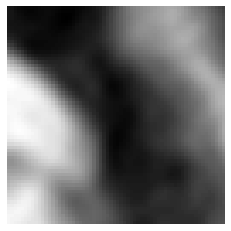

patch 447


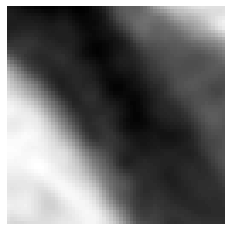

patch 583


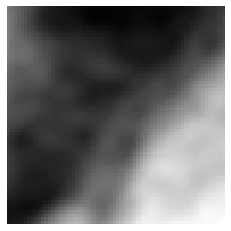

patch 589


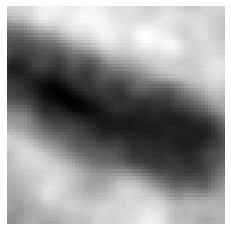

patch 603


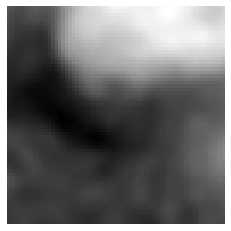

patch 611


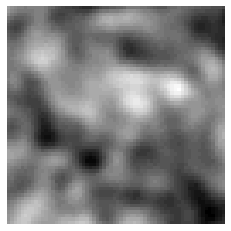

In [62]:
display_input(patches, best_patches_idx, view=1)

patch 396


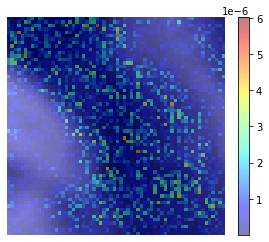

patch 447


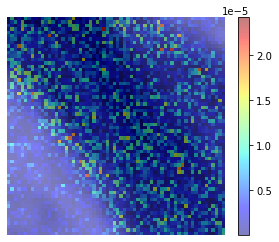

patch 583


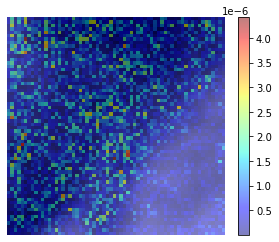

patch 589


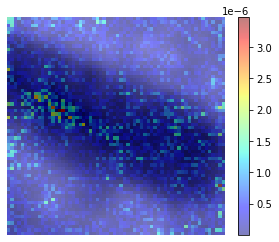

patch 603


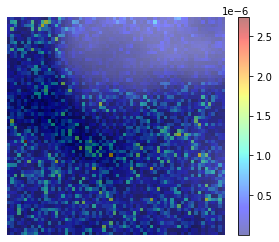

patch 611


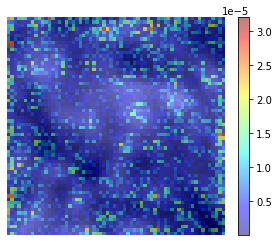

In [61]:
display_grads(patches, grads, best_patches_idx, view=1)

In [116]:
patches, patient_data, mi_target, available_art, net, best_patches_idx = get_all_results_one(None, "RCA", batch_idx, True, 10)
saliency = Saliency(net)
grads = saliency.attribute(patches.requires_grad_(), target=mi_target)

patient14


patch 95


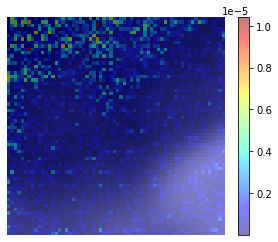

patch 174


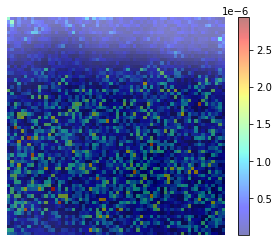

patch 259


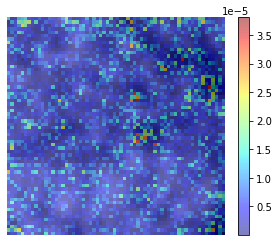

In [119]:
display_grads(patches, grads, best_patches_idx, view=0)

patch 375


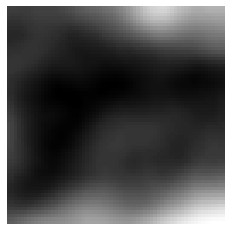

patch 447


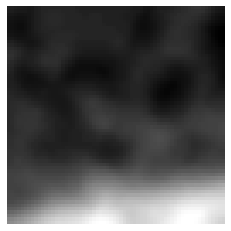

patch 516


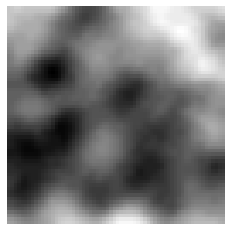

patch 565


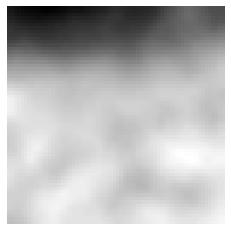

patch 583


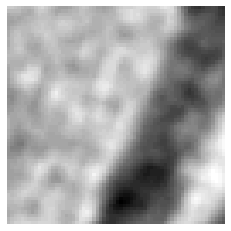

patch 611


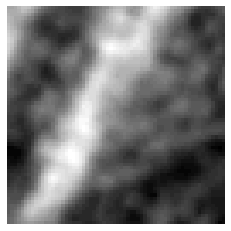

patch 661


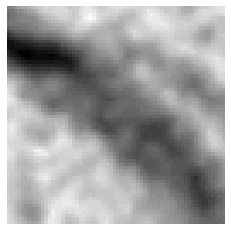

In [118]:
display_input(patches, best_patches_idx, view=1)

In [73]:
patches, patient_data, mi_target, available_art, net, best_patches_idx = get_all_results_one(None, "RCA", 0, True, 10)

Nb of elements in train_data_loader 297
Nb of MI in train data 26
Nb of elements in valid_data_loader 75
Nb of MI in valid data 3


In [74]:
saliency = Saliency(net)
grads = saliency.attribute(patches.requires_grad_(), target=mi_target)

patch 7


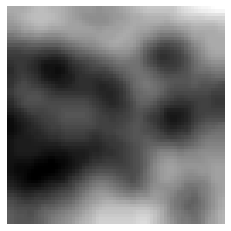

patch 95


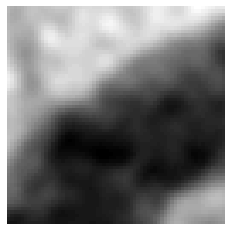

patch 164


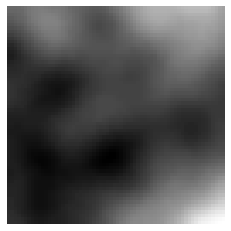

patch 213


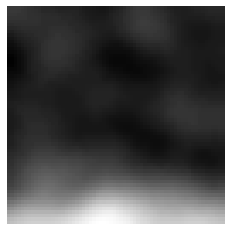

patch 222


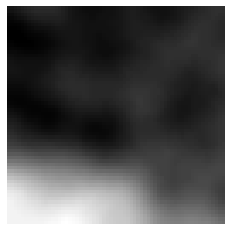

patch 237


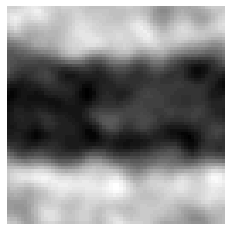

patch 251


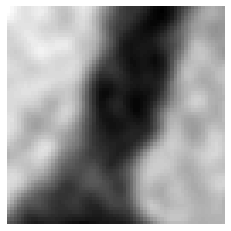

patch 259


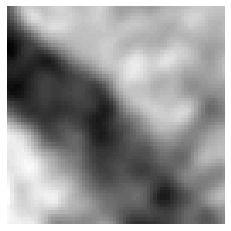

patch 286


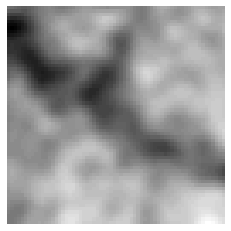

patch 309


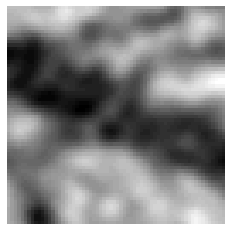

In [75]:
display_input(patches, best_patches_idx)

patch 7


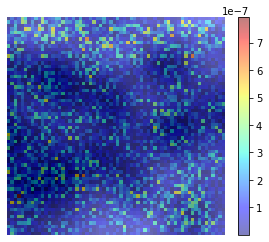

patch 95


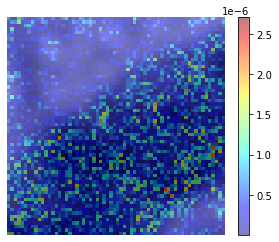

patch 164


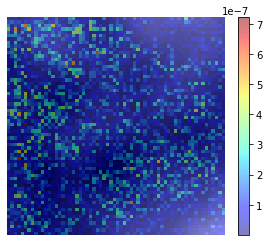

patch 213


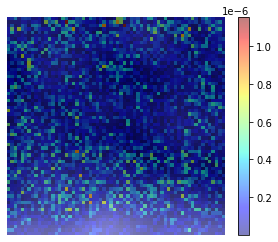

patch 222


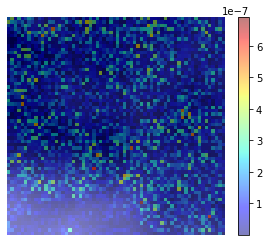

patch 237


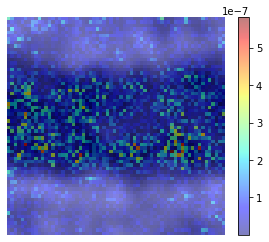

patch 251


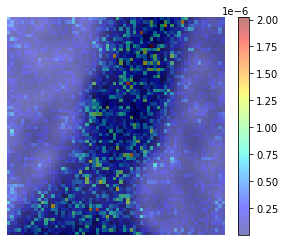

patch 259


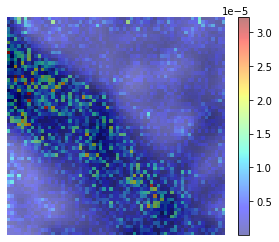

patch 286


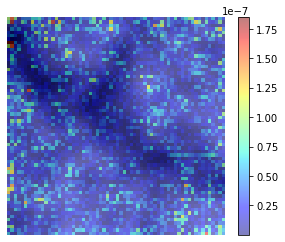

patch 309


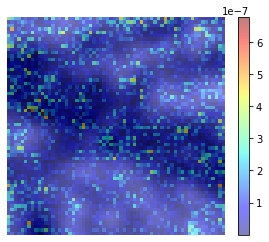

In [76]:
display_grads(patches, grads, best_patches_idx)